In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt

### Prep data

In [2]:
MAX_IMAGE_SIZE = 32
BACKGROUND_CLASS = 10
NUM_CLASSES = 11  # 0–9 colors + background

def placeholder(arg, sizes=(MAX_IMAGE_SIZE, MAX_IMAGE_SIZE), background=BACKGROUND_CLASS):
    img = np.array(arg)
    holder = np.full(sizes, background, dtype=int)
    holder[:img.shape[0], :img.shape[1]] = img
    return holder

Loaded 427 train pairs from ConceptARC


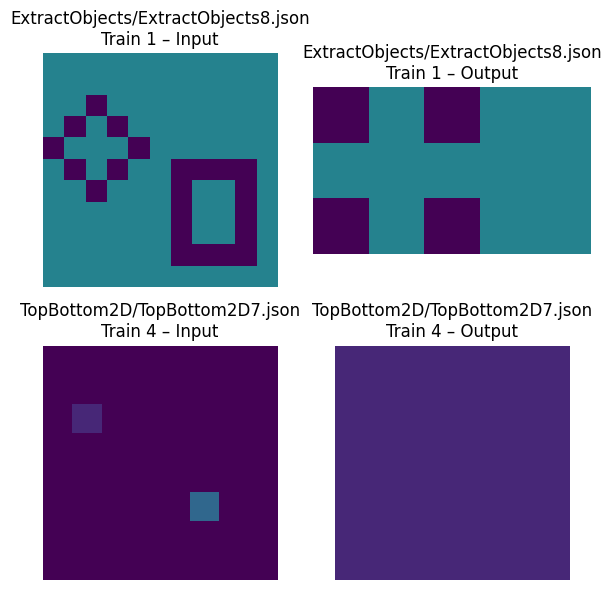

In [3]:
# ============================================================
# Config
# ============================================================
ROOT_DIR = "ConceptARC/corpus"

# ============================================================
# Visualization utils
# ============================================================
def show_grid(ax, grid, title):
    ax.imshow(grid, interpolation="nearest", vmin=0, vmax=9)
    ax.set_title(title)
    ax.axis("off")

# ============================================================
# Load all train pairs from all JSON files
# ============================================================
all_pairs = []  # (task_name, pair_idx, input, output)

for root, _, files in os.walk(ROOT_DIR):
    for fname in files:
        if not fname.endswith(".json"):
            continue

        json_path = os.path.join(root, fname)
        task_name = os.path.relpath(json_path, ROOT_DIR)

        with open(json_path, "r") as f:
            data = json.load(f)

        for i, pair in enumerate(data.get("train", [])):
            inp = np.array(pair["input"])
            out = np.array(pair["output"])
            all_pairs.append((task_name, i, inp, out))

print(f"Loaded {len(all_pairs)} train pairs from ConceptARC")

# ============================================================
# Sample random pairs
# ============================================================
N_SAMPLES = 2
SEED = 0
random.seed(SEED)

samples = random.sample(all_pairs, k=min(N_SAMPLES, len(all_pairs)))

# ============================================================
# Display
# ============================================================
fig, axes = plt.subplots(len(samples), 2, figsize=(6, 3 * len(samples)))

if len(samples) == 1:
    axes = np.expand_dims(axes, axis=0)

for row, (task, idx, inp, out) in enumerate(samples):
    show_grid(axes[row, 0], inp, f"{task}\nTrain {idx} – Input")
    show_grid(axes[row, 1], out, f"{task}\nTrain {idx} – Output")

plt.tight_layout()
plt.show()

In [4]:
# # path to your file
# json_path = "ConceptARC/corpus/TopBottom2D/TopBottom2D7.json"

# # load json
# with open(json_path, "r") as f:
#     data = json.load(f)

# train_pairs = data["train"]

# def show_grid(ax, grid, title):
#     ax.imshow(grid, interpolation="nearest", vmin=0, vmax=9)
#     ax.set_title(title)
#     ax.axis("off")

# # display all train input/output pairs
# for i, pair in enumerate(train_pairs):
#     inp = placeholder(np.array(pair["input"]))
#     out = placeholder(np.array(pair["output"]))

#     fig, axes = plt.subplots(1, 2, figsize=(6, 3))
#     show_grid(axes[0], inp, f"Train {i} – Input")
#     show_grid(axes[1], out, f"Train {i} – Output")

#     plt.tight_layout()
#     plt.show()

In [5]:
images = []

for task_name, pair_idx, input, output in all_pairs:
    grid = placeholder(input) 
    images.append(grid)
    grid = placeholder(output)
    images.append(grid)

In [6]:
# # ============================================================
# # Sytactic dataet for testing compositional generalization
# # ============================================================

# GRID = 4
# NUM_COLORS = 4
# N_COMPONENTS = 4

# # simple ARC-like color map
# COLORS = [
#     (0, 0, 0),       # background
#     (1, 0, 0),       # red
#     (0, 0, 1),       # blue
#     (0, 1, 0),       # green
# ]

# # ============================================================
# # Primitive generators
# # ============================================================

# def hline(row, color):
#     g = np.zeros((GRID, GRID), dtype=int)
#     g[row, :] = color
#     return g

# def vline(col, color):
#     g = np.zeros((GRID, GRID), dtype=int)
#     g[:, col] = color
#     return g

# # ============================================================
# # Build dataset (16 images from 4 parts)
# # ============================================================

# P1 = hline(1, 1)
# P2 = hline(2, 2)
# P3 = vline(0, 3)
# P4 = vline(3, 1)

# primitives = [P1, P2, P3, P4]

# images = []
# for i in range(16):
#     img = np.zeros((GRID, GRID), dtype=int)
#     if i & 1: img = np.maximum(img, P1)
#     if i & 2: img = np.maximum(img, P2)
#     if i & 4: img = np.maximum(img, P3)
#     if i & 8: img = np.maximum(img, P4)
#     images.append(img)

In [7]:
def one_hot_encode(grid, grid_size=MAX_IMAGE_SIZE, num_colors=NUM_CLASSES):
    out = np.zeros((grid_size, grid_size, num_colors))
    for i in range(grid_size):
        for j in range(grid_size):
            out[i, j, grid[i, j]] = 1
    return out.reshape(-1)

def decode(vec, grid_size=MAX_IMAGE_SIZE, num_colors=NUM_CLASSES):
    return vec.reshape(grid_size, grid_size, num_colors).argmax(axis=-1)

In [8]:
# ============================================================
# Vectorize + NMF
# ============================================================

X = np.stack([one_hot_encode(img, MAX_IMAGE_SIZE, NUM_CLASSES) for img in images])

In [9]:
N_COMPONENTS = 64

### SKlearn

In [10]:
# from sklearn.decomposition import NMF

# nmf = NMF(
#     n_components=64,
#     init="nndsvda",
#     max_iter=100,
#     random_state=0,
#     verbose=1
# )

# W = nmf.fit_transform(X)
# H = nmf.components_

### Pytorch model

In [11]:
import torch
import torch
from torchnmf.nmf import NMF

# V = torch.bernoulli(torch.full((64, 1024), 0.5))
# model = NMF(V.t().shape, rank=10)
# model.fit(V.t())

V = torch.tensor(X).float()

model = NMF(V.t().shape, rank=N_COMPONENTS)

model.cuda()
model.fit(V.cuda().t())

/opt/conda/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


110

In [12]:
import torch

# reconstruction
W = model.W.cpu()
H = model.H.t().cpu()
WH = W @ H

# Frobenius reconstruction loss
loss = torch.norm(V - WH, p='fro') ** 2

print("Reconstruction loss:", loss.item())


# random non-negative W and H with same shapes
W_rand = torch.rand_like(W)
H_rand = torch.rand_like(H)

WH_rand = W_rand @ H_rand

loss_rand = torch.norm(V - WH_rand, p='fro') ** 2

print("Random reconstruction loss:", loss_rand.item())

# W = W.detach().numpy()
# H = H.detach().numpy()

Reconstruction loss: 39667.375
Random reconstruction loss: 2460212224.0


### Visualize

In [13]:
# # ============================================================
# # Visualize NMF components as ARC images
# # ============================================================

# fig, axes = plt.subplots(1, nmf.n_components, figsize=(nmf.n_components * 2.5, 2.5))

# for k in range(nmf.n_components):
#     comp_img = decode(H[k])
#     axes[k].imshow(comp_img, cmap=None)
#     axes[k].set_title(f"Component {k}", fontsize=9)
#     axes[k].axis("off")

# plt.suptitle("NMF Components (Basis Images)", fontsize=12)
# plt.tight_layout()
# plt.show()

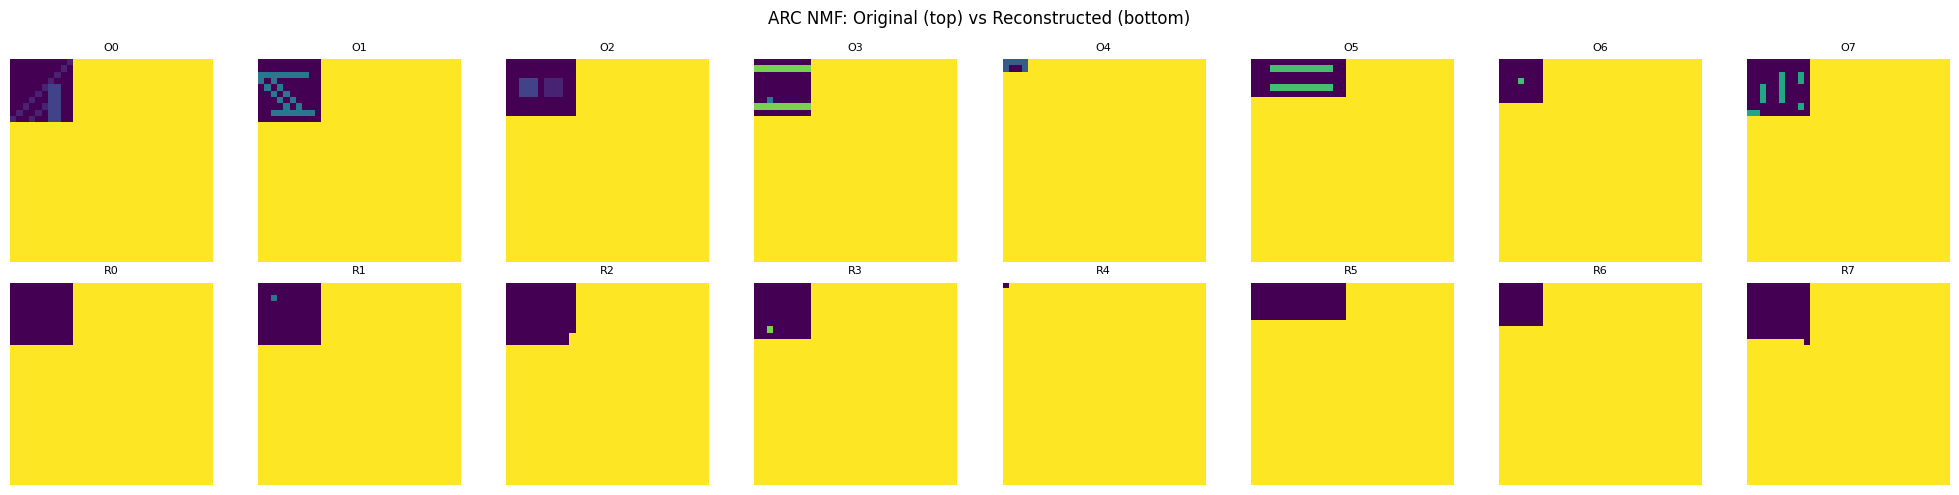

In [18]:
# ============================================================
# Reconstruct all images
# ============================================================

reconstructed = [decode(W[i] @ H) for i in range(len(images))]

# ============================================================
# Plot grid
# ============================================================

n_display = 8 #len(images)
fig, axes = plt.subplots(2, n_display, figsize=(n_display * 2.5, 2 * 2.5))

images_to_display = random.sample(range(1, len(images)), n_display)

for i in range(n_display):
    axes[0, i].imshow(images[images_to_display[i]], cmap=None)
    axes[0, i].set_title(f"O{i}", fontsize=8)
    axes[0, i].axis("off")

    axes[1, i].imshow(reconstructed[images_to_display[i]], cmap=None)
    axes[1, i].set_title(f"R{i}", fontsize=8)
    axes[1, i].axis("off")

fig.suptitle("ARC NMF: Original (top) vs Reconstructed (bottom)", fontsize=12)
plt.tight_layout()
plt.show()

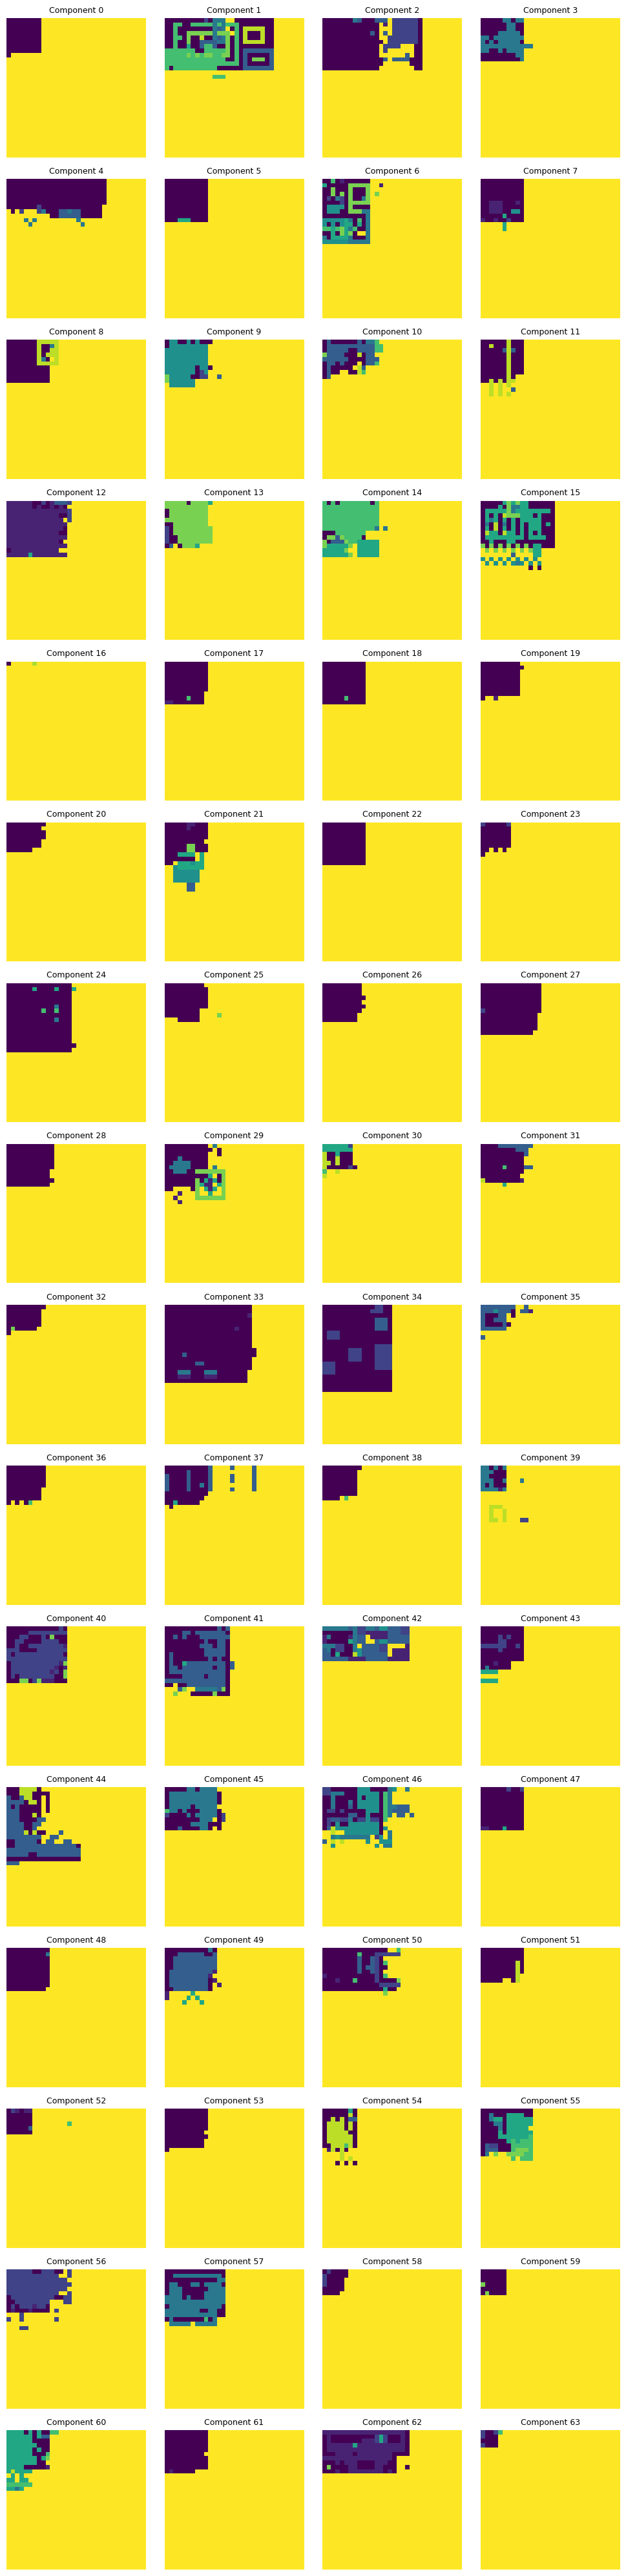

In [15]:
# ============================================================
# Visualize NMF components as ARC images (grid, 4 columns)
# ============================================================

import math
import matplotlib.pyplot as plt

n_components = N_COMPONENTS #nmf.n_components
n_cols = 4
n_rows = math.ceil(n_components / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 2.5, n_rows * 2.5)
)

axes = axes.reshape(-1)  # flatten for easy indexing

for k in range(n_components):
    comp_img = decode(H[k])
    axes[k].imshow(comp_img, cmap=None)
    axes[k].set_title(f"Component {k}", fontsize=9)
    axes[k].axis("off")

# hide unused cells
for k in range(n_components, n_rows * n_cols):
    axes[k].axis("off")

plt.tight_layout()
plt.show()

In [16]:
# # ============================================================
# # Cluster images by dominant NMF component (topic)
# # ============================================================

# topics = np.argmax(W, axis=1)

# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=3, random_state=0)
# topics = kmeans.fit_predict(W)

# from collections import defaultdict

# topic_to_images = defaultdict(list)

# for idx, topic in enumerate(topics):
#     topic_to_images[topic].append(idx)


# # ============================================================
# # Plot images grouped by topic
# # ============================================================

# max_imgs = max(len(v) for v in topic_to_images.values())
# fig, axes = plt.subplots(
#     N_COMPONENTS,
#     max_imgs,
#     figsize=(max_imgs * 1.2, N_COMPONENTS * 1.2)
# )

# for topic in range(N_COMPONENTS):
#     imgs = topic_to_images[topic]
#     for j in range(max_imgs):
#         ax = axes[topic, j] if N_COMPONENTS > 1 else axes[j]

#         if j < len(imgs):
#             img_idx = imgs[j]
#             ax.imshow(images[img_idx])
#             ax.set_title(f"I{img_idx}", fontsize=8)
#         else:
#             ax.axis("off")

#         ax.axis("off")

#     axes[topic, 0].set_ylabel(f"Topic {topic}", fontsize=10)

# fig.suptitle("ARC Images Clustered by NMF Topics", fontsize=14)
# plt.tight_layout()
# plt.show()

#plt.scatter(W[:,0], W[:,1], c=topics)

### Clusterization

In [17]:
W.shape, H.shape

(torch.Size([854, 64]), torch.Size([64, 11264]))

In [18]:
import numpy as np

W = W.detach().numpy()
H = H.detach().numpy()

# --------------------------------------------
# Build delta vectors and ground-truth labels
# --------------------------------------------
deltas = []
labels = []      # coarse ConceptARC category
fine_labels = [] # optional: full task path

for i, (task_name, pair_idx, inp, out) in enumerate(all_pairs):
    w_in  = W[2 * i]
    w_out = W[2 * i + 1]

    delta = w_out - w_in
    deltas.append(delta)

    # coarse category = folder name
    category = task_name.split(os.sep)[0]
    labels.append(category)
    fine_labels.append(task_name)

deltas = np.stack(deltas)
labels = np.array(labels)

In [19]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import normalize

# normalize vectors (important for cosine DBSCAN)
deltas_n = normalize(deltas)

dbscan = DBSCAN(
    eps=0.4,              # <-- tune this
    min_samples=5,
    metric="cosine",
)

cluster_ids = dbscan.fit_predict(deltas_n)

# DBSCAN labels noise as -1
mask = cluster_ids != -1

print("N clusters (excluding noise):", len(set(cluster_ids)) - (1 if -1 in cluster_ids else 0))
print("Noise ratio:", (cluster_ids == -1).mean())

# NMI only on non-noise points
print(
    "NMI:",
    normalized_mutual_info_score(labels[mask], cluster_ids[mask])
)

for eps in [0.2, 0.3, 0.4, 0.5, 0.6]:
    labels_db = DBSCAN(eps=eps, min_samples=5, metric="cosine").fit_predict(deltas_n)
    print(eps, "clusters:", len(set(labels_db)) - (1 if -1 in labels_db else 0))

N clusters (excluding noise): 9
Noise ratio: 0.6182669789227166
NMI: 0.36157781998189564
0.2 clusters: 4
0.3 clusters: 5
0.4 clusters: 9
0.5 clusters: 11
0.6 clusters: 1


In [20]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import normalize
import numpy as np

# normalize (if not already)
deltas_n = normalize(deltas)

hac = AgglomerativeClustering(
    n_clusters=16,        # match KMeans for fair comparison
    metric="cosine",
    linkage="average"
)

cluster_ids = hac.fit_predict(deltas_n)

print(
    "NMI:",
    normalized_mutual_info_score(labels, cluster_ids)
)

NMI: 0.20381847526304947


In [21]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.metrics import normalized_mutual_info_score

# normalize (important)
deltas_n = normalize(deltas)

hac = AgglomerativeClustering(
    n_clusters=16,
    linkage="ward"   # metric is implicitly Euclidean
)

cluster_ids = hac.fit_predict(deltas_n)

print(
    "NMI:",
    normalized_mutual_info_score(labels, cluster_ids)
)

NMI: 0.22764059518736127


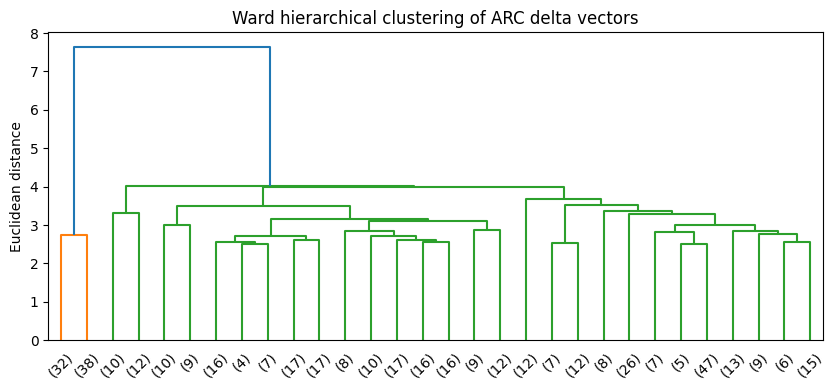

In [22]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

Z = linkage(deltas_n, method="ward")

plt.figure(figsize=(10, 4))
dendrogram(
    Z,
    truncate_mode="lastp",
    p=30,
)
plt.title("Ward hierarchical clustering of ARC delta vectors")
plt.ylabel("Euclidean distance")
plt.show()

In [23]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import normalize
import numpy as np

deltas_n = normalize(deltas)

bandwidth = estimate_bandwidth(
    deltas_n,
    quantile=0.2,   # try 0.1–0.3
    n_samples=500   # subsample for speed
)

print("Estimated bandwidth:", bandwidth)

Estimated bandwidth: 1.333992676935933


In [24]:
ms = MeanShift(
    bandwidth=bandwidth,
    bin_seeding=True
)

cluster_ids = ms.fit_predict(deltas_n)

n_clusters = len(np.unique(cluster_ids))
print("N clusters:", n_clusters)

N clusters: 1


In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import normalize

deltas_n = normalize(deltas)

cluster_ids = KMeans(
    n_clusters=16,
    n_init=30,
    random_state=0
).fit_predict(deltas_n)

print(normalized_mutual_info_score(labels, cluster_ids))

0.25229194787517656


In [26]:
nmi = normalized_mutual_info_score(labels, cluster_ids)
print(f"NMI (true categories vs Δ-clusters): {nmi:.3f}")

NMI (true categories vs Δ-clusters): 0.252


In [27]:
import scipy.stats as st
from collections import Counter

entropies = []

for c in np.unique(cluster_ids):
    cats = labels[cluster_ids == c]
    probs = np.array(list(Counter(cats).values()))
    probs = probs / probs.sum()
    entropies.append(st.entropy(probs))

print("Mean cluster entropy:", np.mean(entropies))
#print(entropies)

Mean cluster entropy: 1.9969898960025376


In [28]:
np.unique(labels)

array(['AboveBelow', 'Center', 'CleanUp', 'CompleteShape', 'Copy',
       'Count', 'ExtendToBoundary', 'ExtractObjects', 'FilledNotFilled',
       'HorizontalVertical', 'InsideOutside', 'MoveToBoundary', 'Order',
       'SameDifferent', 'TopBottom2D', 'TopBottom3D'], dtype='<U18')

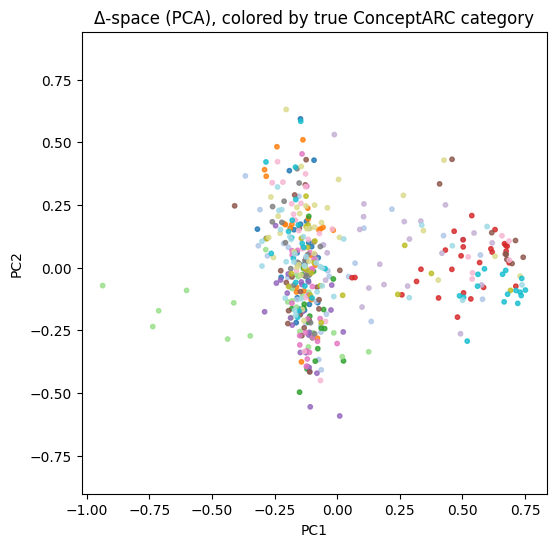

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np

# normalize deltas (important)
deltas_n = normalize(deltas)

# PCA
pca = PCA(n_components=2)
Z = pca.fit_transform(deltas_n)

# map true categories to color ids
categories = sorted(set(labels))
cat_to_id = {c: i for i, c in enumerate(categories)}
colors = np.array([cat_to_id[c] for c in labels])

plt.figure(figsize=(6, 6))
sc = plt.scatter(
    Z[:, 0],
    Z[:, 1],
    c=colors,
    cmap="tab20",
    s=10,
    alpha=0.8
)
plt.axis("equal")
plt.title("Δ-space (PCA), colored by true ConceptARC category")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [30]:
# --------------------------------------------
# Build joint IO vectors
# --------------------------------------------
io_vectors = []
labels = []

for i, (task_name, pair_idx, inp, out) in enumerate(all_pairs):
    w_in  = W[2 * i]
    w_out = W[2 * i + 1]

    z = np.concatenate([w_in, w_out])
    io_vectors.append(z)

    labels.append(task_name.split(os.sep)[0])

io_vectors = np.stack(io_vectors)
labels = np.array(labels)

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import normalize

# normalize vectors (important for cosine DBSCAN)
deltas_n = normalize(io_vectors)

dbscan = DBSCAN(
    eps=0.2,              # <-- tune this
    min_samples=5,
    metric="cosine",
)

cluster_ids = dbscan.fit_predict(deltas_n)

# DBSCAN labels noise as -1
mask = cluster_ids != -1

print("N clusters (excluding noise):", len(set(cluster_ids)) - (1 if -1 in cluster_ids else 0))
print("Noise ratio:", (cluster_ids == -1).mean())

# NMI only on non-noise points
print(
    "NMI:",
    normalized_mutual_info_score(labels[mask], cluster_ids[mask])
)

for eps in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    labels_db = DBSCAN(eps=eps, min_samples=5, metric="cosine").fit_predict(deltas_n)
    print(eps, "clusters:", len(set(labels_db)) - (1 if -1 in labels_db else 0))

N clusters (excluding noise): 7
Noise ratio: 0.6065573770491803
NMI: 0.3244648699856846
0.1 clusters: 6
0.2 clusters: 7
0.3 clusters: 5
0.4 clusters: 2
0.5 clusters: 1
0.6 clusters: 1


In [32]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

Z = normalize(io_vectors)

kmeans = KMeans(
    n_clusters=16,
    n_init=30,
    random_state=0
)

cluster_ids_io = kmeans.fit_predict(Z)

nmi_io = normalized_mutual_info_score(labels, cluster_ids_io)
print(f"NMI (IO vectors vs categories): {nmi_io:.3f}")

NMI (IO vectors vs categories): 0.243


In [33]:
from collections import Counter
import scipy.stats as st

entropies_io = []

for c in np.unique(cluster_ids_io):
    cats = labels[cluster_ids_io == c]
    probs = np.array(list(Counter(cats).values()))
    probs = probs / probs.sum()
    entropies_io.append(st.entropy(probs))

print("Mean cluster entropy (IO):", np.mean(entropies_io))

Mean cluster entropy (IO): 2.065774293761927


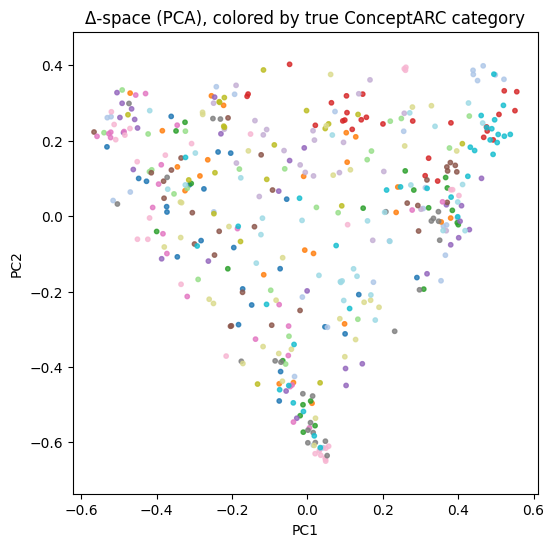

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np

# normalize deltas (important)
io_vectors = normalize(io_vectors)

# PCA
pca = PCA(n_components=2)
Z = pca.fit_transform(io_vectors)

# map true categories to color ids
categories = sorted(set(labels))
cat_to_id = {c: i for i, c in enumerate(categories)}
colors = np.array([cat_to_id[c] for c in labels])

plt.figure(figsize=(6, 6))
sc = plt.scatter(
    Z[:, 0],
    Z[:, 1],
    c=colors,
    cmap="tab20",
    s=10,
    alpha=0.8
)
plt.axis("equal")
plt.title("Δ-space (PCA), colored by true ConceptARC category")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()